<figure>
  <IMG SRC="https://raw.githubusercontent.com/mbakker7/exploratory_computing_with_python/master/tudelft_logo.png" WIDTH=250 ALIGN="right">
</figure>

# Analyse exam results for UTQ ASSESS course
This notebook was tested only on the machine with Ubuntu operating system and may not run on machines with other types of operating systems.

This notebook:

- *Developed by [Dr. Yury Zhauniarovich](https://zhauniarovich.com) (TPM - MAS - OG)* 
- *Inspired by the notebook developed by Dr. Ir. Hessel Winsemius (CEG - Water Management)*
- *Contains information taken from the UTQ Assess Reader document*.

In [2]:
# constants that control the behavior of the notebook

IN_PATHS = {
    'scores_data_file' : './data/test_data_with_grades.csv'
}
OUT_PATHS = {
    'figs_dir' : './results/figs/',
    'res_csv_dir' : './results/csvs/',
}


# Column StudentID
INDEX_COLUMN = 'StudentID'
# Column with grades. If there are no grades put None, then the grades will be computed automatically. 
GRADE_COLUMN = 'Grade' # None  

# ID of the row with the information about the weights. It should be put into the INDEX_COLUMN
ROWID_WEIGHT = 'weight'
# ID of the row with the information about the minimum theoretical scores. It should be put into the INDEX_COLUMN
ROWID_MIN_THEORETICAL_SCORE = 'min_score'
# ID of the row with the information about the maximum theoretical scores. It should be put into the INDEX_COLUMN
ROWID_MAX_THEORETICAL_SCORE = 'max_score'
# ID of the row with the information about guess probablitiy. It should be put into the INDEX_COLUMN
ROWID_GUESS_PROBA_PERC = 'guess_proba_perc'

# If row with ROWID == ROWID_MIN_THEORETICAL_SCORE is not found then this value will be taken as the minimum theoretical score for all questions  
DEFAULT_MIN_SCORE = 0
# If row with ROWID == ROWID_MAX_THEORETICAL_SCORE is not found then this value will be taken as the maximum theoretical score for all questions  
DEFAULT_MAX_SCORE = 10
# If row with ROWID == ROWID_GUESS_PROBA_PERC is not found then this value will be taken as the default guess probability  
DEFAULT_GUESS_PROBA_PERC = 0


# Minimum possible grade
MIN_GRADE = 1
# Maximum possible grade
MAX_GRADE = 10

# CUTOFF SCORE - currently is not implemented in this notebook
CUTOFF_SCORE = None
# CUTOFF GRADE - minimum grade to pass the exam
CUTOFF_GRADE = 5.8


COMPUTED_GRADE_COLUMN = 'CALC_GRADE'
STUDENT_SCORE_POINTS_COLUMN = 'STUDENT_SCORE_POINTS'

# matplotlib constants
FIGSIZE = (8, 6)      # the size of the final figures in inches
SAVE_FIG = True       # should the figures be stored
FIG_FMT = 'png'       # the format in which store the figures (matplotlib supported, e.g., png, pdf)
TRANSPARENT_PNG=False # if the PNG figure should have a transparent background

In [3]:
# imports
import os
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

# matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
plt.style.use('seaborn-colorblind')

# this package is requried to store styled dataframes as images
# tested by storing them in the png format 
import dataframe_image as dfi 

In [4]:
# auxiliary functions
def read_data(pth):
    data_df = pd.read_csv(pth, index_col=INDEX_COLUMN)

    try:
        grades = data_df[GRADE_COLUMN].copy()
    except KeyError:
        grades = None
    else:
        data_df = data_df.drop(columns=GRADE_COLUMN)
        grades = grades.drop(
            grades[grades.index.isin([
                ROWID_WEIGHT,
                ROWID_MIN_THEORETICAL_SCORE,
                ROWID_MAX_THEORETICAL_SCORE,
                ROWID_GUESS_PROBA_PERC,
            ])].index
        ).to_numpy(dtype=np.float64)
    
    number_of_criteria = len(data_df.columns)
    weights_data = data_df[data_df.index==ROWID_WEIGHT]
    if len(weights_data) > 0:
        weights = weights_data.to_numpy(dtype=np.float64)[0]
        data_df = data_df.drop(weights_data.index)
    else:
        weights = np.full(
            (1, number_of_criteria), 
            1, 
            dtype=np.float64
        )
    min_theoretical_scores_data = data_df[data_df.index==ROWID_MIN_THEORETICAL_SCORE]
    if len(min_theoretical_scores_data) > 0:
        min_theoretical_scores = min_theoretical_scores_data.to_numpy(dtype=np.float64)[0]
        data_df = data_df.drop(min_theoretical_scores_data.index)
    else:
        min_theoretical_scores = np.full(
            (1, number_of_criteria), 
            DEFAULT_MIN_SCORE, 
            dtype=np.float64
        )
    max_theoretical_scores_data = data_df[data_df.index==ROWID_MAX_THEORETICAL_SCORE]
    if len(max_theoretical_scores_data) > 0:
        max_theoretical_scores = max_theoretical_scores_data.to_numpy(dtype=np.float64)[0]
        data_df = data_df.drop(max_theoretical_scores_data.index)
    else:
        max_theoretical_scores = np.full(
            (1, number_of_criteria), 
            DEFAULT_MAX_SCORE, 
            dtype=np.float64
        )
    guess_proba_data = data_df[data_df.index==ROWID_GUESS_PROBA_PERC]
    if len(guess_proba_data) > 0:
        guess_proba_perc = guess_proba_data.to_numpy(dtype=np.float64)[0]
        data_df = data_df.drop(guess_proba_data.index)
    else:
        guess_proba_perc = np.full(
            shape=(number_of_criteria), 
            fill_value=DEFAULT_GUESS_PROBA_PERC, 
            dtype=np.float64
        )
        # guess_proba_perc = np.array(

        # )

    return (
        data_df, 
        grades, 
        weights, 
        min_theoretical_scores, 
        max_theoretical_scores, 
        guess_proba_perc,
    )


def save_fig(
        fig, 
        fig_name: str, 
        fig_dir: str, 
        fig_fmt: str, 
        save: bool=True, 
        dpi: int=300,
        transparent_png=True,
    ):
    """This procedure stores the generated matplotlib figure to the specified 
    directory with the specified name and format.

    Parameters
    ----------
    fig : [type]
        [description]
    fig_name : str
        [description]
    fig_dir : str
        [description]
    fig_fmt : str
        [description]
    save : bool, optional
        [description], by default True
    dpi : int, optional
        [description], by default 300
    transparent_png : bool, optional
        [description], by default True
    """
    if not save:
        return
    fig_fmt = fig_fmt.lower()
    fig_dir = os.path.join(fig_dir, fig_fmt)
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    pth = os.path.join(
        fig_dir,
        '{}.{}'.format(fig_name, fig_fmt.lower())
    )
    if fig_fmt == 'pdf':
        fig.savefig(pth, bbox_inches='tight')
    elif fig_fmt == 'png':
        alpha = 0 if transparent_png else 1
        axes = fig.get_axes()
        fig.patch.set_alpha(alpha)
        for ax in axes:
            ax.patch.set_alpha(alpha)
        fig.savefig(
            pth, 
            bbox_inches='tight',
            dpi=dpi,
            # edgecolor='none',
        )
    else:
        try:
            fig.savefig(pth, bbox_inches='tight')
        except Exception as e:
            print("Cannot save figure: {}".format(e)) 


def export_styled_df(
    df_styler, 
    fig_name: str, 
    fig_dir: str, 
    fig_fmt: str, 
    save: bool=True,
):
    if not save:
        return
    fig_fmt = fig_fmt.lower()
    fig_dir = os.path.join(fig_dir, fig_fmt)
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    pth = os.path.join(
        fig_dir,
        '{}.{}'.format(fig_name, fig_fmt.lower())
    )
    dfi.export(
        df_styler,
        pth,
    )


def check_paths(in_paths, out_paths):
    """
    This auxiliary function checks the input and output paths used for data 
    analysis.

    Parameters
    ----------
    in_paths : Dict[srt, str]
        A dictionary with input paths. If a key ends with '_dir' an 
        additional check is performed to figure out if the corresponding path 
        corresponds to an existing directory.  
    out_paths : Dict[srt, str]
        A dictionary with output paths. If a key ends with '_dir' the function 
        will trim the path to the directory. If the directory does not exist it 
        will be created.
    """    
    for pth_key in in_paths:
        pth = in_paths[pth_key]
        if not os.path.exists(pth):
            print('Path [{}] does not exist'.format(pth))
        if pth_key.endswith('_dir') and (not os.path.isdir(pth)):
            print('Path [{0}] does not correspond to a directory!'.format(pth))

    for pth_key in out_paths:
        pth = out_paths[pth_key]
        if pth_key.endswith('_dir'):
            abs_path = os.path.abspath(pth)
        else:
            abs_path = os.path.abspath(os.path.dirname(pth))
        if not os.path.exists(abs_path):
            print('Creating path: [{}]'.format(abs_path))
            os.makedirs(abs_path)



In [43]:
# it would be possible to save a matplotlib figure with the following command:
# savefig(fig, 'figure_name')
from functools import partial
savefig = partial(save_fig, fig_dir=OUT_PATHS['figs_dir'], fig_fmt=FIG_FMT, save=SAVE_FIG, transparent_png=TRANSPARENT_PNG) 
export_df = partial(export_styled_df, fig_dir=OUT_PATHS['figs_dir'], fig_fmt=FIG_FMT, save=SAVE_FIG,)

# checking the paths
check_paths(IN_PATHS, OUT_PATHS)

## Loading and Preprocessing Data

In [6]:
# loading data
scores_df, grades, weights, min_theoretical_scores, max_theoretical_scores, guess_proba_perc = read_data(IN_PATHS['scores_data_file'])

In [7]:
criteria = scores_df.columns
print('Criteria used: {}'.format(', '.join(criteria)))

Criteria used: Speed, Fuel consumption, Design, Production costs, Aerodynamics, Summary, Correctness, Completeness, Presentation, Contribution


In [8]:
# number of students and number of questions from the dataframe
n_students, n_questions = scores_df.shape
print(f'number of students: {n_students}, number of questions: {n_questions}')

number of students: 31, number of questions: 10


In [9]:
# normalized weights: I do not assume any preliminary knowledge about the sum of individual questions weighs
normalized_weights = weights / sum(weights)
print(normalized_weights)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


In [10]:
scores_df.head(5)

,Speed,Fuel consumption,Design,Production costs,Aerodynamics,Summary,Correctness,Completeness,Presentation,Contribution
StudentID,,,,,,,,,,
1,4,4,6,4,4,4,4,4,6,2
2,10,5,10,8,5,10,3,8,7,7
3,3,5,6,6,4,6,2,9,6,1
4,10,5,7,4,8,10,0,4,2,2
5,9,5,10,7,7,7,10,4,4,4


In [11]:
normalized_scores_df = pd.DataFrame((scores_df - min_theoretical_scores)/(max_theoretical_scores - min_theoretical_scores), dtype=np.float64)
normalized_scores_df.head(5)

,Speed,Fuel consumption,Design,Production costs,Aerodynamics,Summary,Correctness,Completeness,Presentation,Contribution
StudentID,,,,,,,,,,
1,0.4,0.4,0.6,0.4,0.4,0.4,0.4,0.4,0.6,0.2
2,1.0,0.5,1.0,0.8,0.5,1.0,0.3,0.8,0.7,0.7
3,0.3,0.5,0.6,0.6,0.4,0.6,0.2,0.9,0.6,0.1
4,1.0,0.5,0.7,0.4,0.8,1.0,0.0,0.4,0.2,0.2
5,0.9,0.5,1.0,0.7,0.7,0.7,1.0,0.4,0.4,0.4


In [12]:
normalized_weighted_scores_df = pd.DataFrame(normalized_scores_df * normalized_weights, dtype=np.float64)
normalized_weighted_scores_df.head(5)

,Speed,Fuel consumption,Design,Production costs,Aerodynamics,Summary,Correctness,Completeness,Presentation,Contribution
StudentID,,,,,,,,,,
1,0.04,0.04,0.06,0.04,0.04,0.04,0.04,0.04,0.06,0.02
2,0.10,0.05,0.10,0.08,0.05,0.10,0.03,0.08,0.07,0.07
3,0.03,0.05,0.06,0.06,0.04,0.06,0.02,0.09,0.06,0.01
4,0.10,0.05,0.07,0.04,0.08,0.10,0.00,0.04,0.02,0.02
5,0.09,0.05,0.10,0.07,0.07,0.07,0.10,0.04,0.04,0.04


In [13]:
score_points_df = pd.DataFrame(100*normalized_weighted_scores_df, dtype=np.float64)
score_points_df.head(5)

,Speed,Fuel consumption,Design,Production costs,Aerodynamics,Summary,Correctness,Completeness,Presentation,Contribution
StudentID,,,,,,,,,,
1,4.0,4.0,6.0,4.0,4.0,4.0,4.0,4.0,6.0,2.0
2,10.0,5.0,10.0,8.0,5.0,10.0,3.0,8.0,7.0,7.0
3,3.0,5.0,6.0,6.0,4.0,6.0,2.0,9.0,6.0,1.0
4,10.0,5.0,7.0,4.0,8.0,10.0,0.0,4.0,2.0,2.0
5,9.0,5.0,10.0,7.0,7.0,7.0,10.0,4.0,4.0,4.0


In [14]:
print(guess_proba_perc)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [15]:
# normalized weighted guess scores
normalized_weighted_guess_scores = normalized_weights * guess_proba_perc / 100
print(normalized_weighted_guess_scores)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [16]:
guess_score_points = 100 * normalized_weighted_guess_scores
print(guess_score_points)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


---

## Analysis

### Items Statistics

#### p-value

$p$ is the average, normalized score and has a value between 0 (no points) to 1 (full score). The higher $p$, the higher your students scored on this item, and the easier the question or the criterion. For closed questions, $p$ equals the fraction of students who answered the question correctly.

$p$ is a reverse measure for the difficulty of an item.

**Formulas:**

$$
p_j = \frac{\sum_{i=1}^{N_{stud}} s_i}{N_{stud}\cdot S_j}
$$

Where:
* $p_j$ - the $p$-value for subquestion $j$,
* $N_{stud}$ - the total number of students,
* $S_j$ the maximum score of subquestion $j$, 
* $s_i$ the score of student $i$ on subquestion $j$.


In [17]:
p = scores_df.sum(axis=0) / (n_students * max_theoretical_scores)
p_mean = p.mean()

In [18]:
print(f'Average difficulty: {p_mean:.2f}')

Average difficulty: 0.66


#### Item discrimination


**Item discrimination** is the ability of an item to distinguish between good and poor performing students. If the item discrimination is high, good performing students answer the question correctly and poor performing students answer the question incorrectly.

There are two item discrimination coefficients: $R_{it}$ and $R_{ir}$. You can always use RiR, but not always the $R_{it}$.

Keep in mind that discrimination may be low if the item could be improved, but also if engaging in the learning activities did not contribute to getting a high score on this item. Either students already knew/mastered this before entering the course, or they did not get enough/effective learning activities during the course.

|  $R_{it}$ and $R_{ir}$ | Item discrimination quality |
|------------------------|-----------------------------|
| **[0.4, 1]**           | Very good                   |
| **[0.3, 0.4)**         | Good                        |
| **[0.2, 0.3)**         | Mediocre, the question should be improved |
| **[0.0, 0.2)**         | Bad, the question should not be |
| **[-1.0, 0.0)**        | Bad, good students have answered the question incorrectly and vice versa |


##### Item Total Score ($R_{it}$)

**Formula:**

$$
R_{{it}_j} = \frac{\sum_{i=1}^{N_{stud}} (x_i - \mu)(s_i - \mu_j)}{\sqrt{\sum_{i=1}^{N_{stud}} (x_i - \mu)^2 \sum_{i=1}^{N_{stud} } (s_i - \mu_j)^2}}
$$

Where:
* $N_{stud}$ - the total number of students,
* $x_i$ - the final score of student $i$,
* $\mu$ - the mean final score,
* $s_i$ - the subquestion score of student $i$ on subquestion $j$,
* $\mu_j$ - the mean score on subquestion $j$.


In [19]:
sum_norm_weighted_scores = normalized_weighted_scores_df.sum(axis=1)
Rit = normalized_weighted_scores_df.corrwith(sum_norm_weighted_scores)

##### Item Rest Score ($R_{ir}$)

**Formula:**

$$
R_{{ir}_j} = \frac{\sum_{i=1}^{N_{stud}} ((x_i - s_i) - {\~\mu_J})(s_i - \mu_j)}{\sqrt{\sum_{i=1}^{N_{stud}} ((x_i - s_i) - {\~\mu_J})^2 \sum_{i=1}^{N_{stud} } (s_i - \mu_j)^2}}
$$

Where:
* $N_{stud}$ - the total number of students,
* $x_i$ - the final score of student $i$,
* $\mu$ - the mean final score,
* $s_i$ - the subquestion score of student $i$ on subquestion $j$,
* $\mu_j$ - the mean score on subquestion $j$,
* ${\~\mu_J}$ - the mean test score calculated from all
subquestion scores minus the score from subquestion $j$.

In [20]:
sumrest_norm_weighted_scores = pd.DataFrame([normalized_weighted_scores_df.drop(columns=i).sum(axis=1) for i in normalized_weighted_scores_df.columns], index=normalized_weighted_scores_df.columns).transpose()
Rir = normalized_weighted_scores_df.corrwith(sumrest_norm_weighted_scores)

### Test Statistics

####  Reliability of the test (Cronbach’s alpha)

Reliability coefficients are a measure of whether students are performing consistently well on all test items. This is also called the *internal consistency of the test*. It is the extent to which the outcome of the assessment is **not** influenced by coincidence.

***Cronbach’s alpha ($\alpha$)*** estimates the test-retest by considering each question in the test as a separate test and then calculating the correlation between the questions.

The **value of $\alpha$** always lies between 1 and 0. The closer the value is to 1, the smaller the measurement error. A lower reliability can mean that a student whose ‘true score’ is just above the cut-off score may fail the test due to test inaccuracy. Test reliability is very important when the consequences of the test results are large, and therefore the reliability coefficient should be higher for tests of higher stakes. Grades can be considered reliable if Cronbach’s alpha is high enough.


| Type of assessment                                           | Cronbach’s alpha |
|--------------------------------------------------------------|------------------|
| High stake assessment (e.g.,  the only assessment of course) | $\alpha \ge 0.8$            |
| Medium/low stake assessment  (e.g., 50% of final grade):     | $\alpha \ge 0.7$          |
| Formative assessment (e.g., 0% of final grade)               | $\alpha \ge 0.6$          |


**Formulas:**

$$
\alpha = \frac{K}{K-1}\cdot \frac{\sigma_x^2 - \sum_{j=1}^K \sigma_j^2}{\sigma_x^2}
$$

Where:

* $\alpha$ - the reliability coefficient,
* $K$ - the total number of subquestions,
* $\sigma_x^2$ - the variance in the final scores of all students

Where:

$$
\sigma_x^2 = \frac{1}{N_{stud}}\cdot \sum_{i=1}^{N_{stud}} (x_i - \mu)^2
$$

* $N_{stud}$ - the total number of students, 
* $x_i$ - the final score of student $i$,
* $\mu$ - the mean final score.

$$
\sigma_j^2 = \frac{1}{N_{stud}}\cdot \sum_{i=1}^{N_{stud}} (s_i - \mu_j)^2
$$

Where:
* $s_i$ - the subquestion score of student $i$ on subquestion $j$,
* $\mu_j$ - the mean score on subquestion j



In [21]:
sum_norm_weighted_scores = normalized_weighted_scores_df.sum(axis=1)
stdev = normalized_weighted_scores_df.std(axis=0)
sigx = sum_norm_weighted_scores.std()

In [22]:
sum_sp_per_student = score_points_df.sum(axis=1)
stdev_sp = score_points_df.std(axis=0)
sigx_sp = sum_sp_per_student.std()

In [23]:
alpha = n_questions/(n_questions - 1)*(sigx**2-(stdev**2).sum())/sigx**2
# alpha_perc = n_questions/(n_questions - 1)*(sigx_perc**2-(stdev_perc**2).sum())/sigx_perc**2

In [24]:
print(f"Cronbach's alpha: {alpha:.2f}")

Cronbach's alpha: 0.77


#### Standard Error of Measurement ($SEM$)


Test theory assumes that every student has a true score, which reflects that student's actual capability in the area of expertise that an assessment is testing. If a student would take the same test an infinite amount of times, the average of all these scores would constitute the true score. However, *the score of a student taking a test once is always the measurement of the true score plus the measurement error, either systematic of accidental*.

For the sake of reliability of an assessment, which primary goal is to sort students in terms of pass and fail, it is important that this error of measurement is as small as possible, so that based on actual capability, a student passing should actually pass and a student failing should actually fail.

**Standard Error of Measurement ($SEM$)** is used to find the confidence interval for individual students with which can be ascertained that the pass or fail they have achieved reflects actual capability.

**Formula:**

$$
SEM(x) = SD(x)\sqrt{1 - \alpha}
$$

In [25]:
SEM = sigx*(1-alpha)**0.5
SEM_SP = sigx_sp*(1-alpha)**0.5

In [26]:
print(f"Standard Error of Measurement (for normalized weighted scores): {SEM:.4f}")
print(f"Standard Error of Measurement (in score points): {SEM_SP:.2f}")

Standard Error of Measurement (for normalized weighted scores): 0.0620
Standard Error of Measurement (in score points): 6.20


#### Confidence Interval of Scores 

Having $SEM$, we can  calculate the 68% and 95% confidence intervals. 
- 68%: $[test\_score-1*SEM, test\_score+1*SEM]$
- 95%: $[test\_score-2*SEM, test\_score+2*SEM]$

In [27]:
score_points_df[STUDENT_SCORE_POINTS_COLUMN] = score_points_df[criteria].sum(axis=1)
score_points_df['MIN_CI_68'] = score_points_df[STUDENT_SCORE_POINTS_COLUMN] - 1*SEM_SP
score_points_df['MAX_CI_68'] = score_points_df[STUDENT_SCORE_POINTS_COLUMN] + 1*SEM_SP
score_points_df['MIN_CI_95'] = score_points_df[STUDENT_SCORE_POINTS_COLUMN] - 2*SEM_SP
score_points_df['MAX_CI_95'] = score_points_df[STUDENT_SCORE_POINTS_COLUMN] + 2*SEM_SP

In [28]:
score_points_df.head(5)

,Speed,Fuel consumption,Design,Production costs,Aerodynamics,Summary,Correctness,Completeness,Presentation,Contribution,STUDENT_SCORE_POINTS,MIN_CI_68,MAX_CI_68,MIN_CI_95,MAX_CI_95
StudentID,,,,,,,,,,,,,,,
1,4.0,4.0,6.0,4.0,4.0,4.0,4.0,4.0,6.0,2.0,42.0,35.798563,48.201437,29.597125,54.402875
2,10.0,5.0,10.0,8.0,5.0,10.0,3.0,8.0,7.0,7.0,73.0,66.798563,79.201437,60.597125,85.402875
3,3.0,5.0,6.0,6.0,4.0,6.0,2.0,9.0,6.0,1.0,48.0,41.798563,54.201437,35.597125,60.402875
4,10.0,5.0,7.0,4.0,8.0,10.0,0.0,4.0,2.0,2.0,52.0,45.798563,58.201437,39.597125,64.402875
5,9.0,5.0,10.0,7.0,7.0,7.0,10.0,4.0,4.0,4.0,67.0,60.798563,73.201437,54.597125,79.402875


#### Grades

There are two ways how to calculate grades: 
* when the cut-off score is calculated automatically,
* when you specify cut-off score

**Formulas (the grades are between 1 and 10 in this case):**

- When the cut-off score is calculated automatically

$$
grade = max\{1; 1+9 * \frac{(s - gs)}{(ms - gs)}\}
$$

$$
grade = max\{1; 10 * \frac{(s - gs)}{(ms - gs)}\}
$$

- When you specify cut-off score

$$
grade = \begin{cases} 1 + s*\frac{5}{cos}, & s < cos, \\  \frac{6ms - 10cos + 4s}{ms - cos},  & s \ge cos\end{cases}
$$

Where:
* $grade$ - the resulting grade
* $s$ - the obtained score by an individual student
* $gs$ - the guessing score (average obtained score of random guessing
* $ms$ - the maximum score 
* $max\{a;b\}$ the maximum value of $a$ and $b$.



In [29]:
def grade_sum(score_sp, guess_sp, max_sp=100):
    grade = max(MIN_GRADE, MIN_GRADE + (MAX_GRADE - MIN_GRADE)*(score_sp - guess_sp) / (max_sp - guess_sp))
    return grade if grade < MAX_GRADE else MAX_GRADE 

def grade_mult(score_sp, guess_sp, max_sp=100):
    grade = max(MIN_GRADE, MIN_GRADE + (MAX_GRADE - MIN_GRADE)*(score_sp - guess_sp) / (max_sp - guess_sp))
    return grade if grade < MAX_GRADE else MAX_GRADE

# TODO: Implement the score
# def grade_with_cutoff(cutoff_score_sp, score_sp, guess_sp, max_sp=100, cutoff_grade = ):
#     if score_sp < cutoff_sp:
#         grade = 1 + 

In [30]:
# if in the initial dataset there were grades then we add this to the final students dataset too
if grades is not None:
    score_points_df[GRADE_COLUMN] = grades

In [31]:
guess_sp_sum = guess_score_points.sum()
if CUTOFF_SCORE:
    # TODO: to implement
    pass
else: 
    score_points_df[COMPUTED_GRADE_COLUMN] = score_points_df.apply(
        lambda row: grade_sum(row[STUDENT_SCORE_POINTS_COLUMN], guess_sp_sum),
        axis = 1 
    )

In [32]:
score_points_df.head(5)

,Speed,Fuel consumption,Design,Production costs,Aerodynamics,Summary,Correctness,Completeness,Presentation,Contribution,STUDENT_SCORE_POINTS,MIN_CI_68,MAX_CI_68,MIN_CI_95,MAX_CI_95,Grade,CALC_GRADE
StudentID,,,,,,,,,,,,,,,,,
1,4.0,4.0,6.0,4.0,4.0,4.0,4.0,4.0,6.0,2.0,42.0,35.798563,48.201437,29.597125,54.402875,7.1,4.78
2,10.0,5.0,10.0,8.0,5.0,10.0,3.0,8.0,7.0,7.0,73.0,66.798563,79.201437,60.597125,85.402875,6.9,7.57
3,3.0,5.0,6.0,6.0,4.0,6.0,2.0,9.0,6.0,1.0,48.0,41.798563,54.201437,35.597125,60.402875,4.2,5.32
4,10.0,5.0,7.0,4.0,8.0,10.0,0.0,4.0,2.0,2.0,52.0,45.798563,58.201437,39.597125,64.402875,5.7,5.68
5,9.0,5.0,10.0,7.0,7.0,7.0,10.0,4.0,4.0,4.0,67.0,60.798563,73.201437,54.597125,79.402875,7.7,7.03


### Final DataFrames

#### Related to Whole Test

In [33]:
final_test_res_data = {
    'min_student_score_points' : score_points_df[STUDENT_SCORE_POINTS_COLUMN].min(),
    'max_student_score_points' : score_points_df[STUDENT_SCORE_POINTS_COLUMN].max(),
    'min_computed_grade' : score_points_df[COMPUTED_GRADE_COLUMN].min(),
    'max_computed_grade' : score_points_df[COMPUTED_GRADE_COLUMN].max(),
    'p_mean' : p_mean,
    'Rit_mean' : Rit.mean(),
    'Rir_mean' : Rir.mean(),
    'alpha' : alpha,
    'SEM_SP' : SEM_SP,
}

In [34]:
final_test_df = pd.DataFrame.from_dict(final_test_res_data, orient='index', columns=['Value'])
final_test_df.index.rename('Parameter', inplace=True)

In [35]:
final_test_df.head(10)

,Value
Parameter,
min_student_score_points,41.000000
max_student_score_points,85.000000
min_computed_grade,4.690000
max_computed_grade,8.650000
p_mean,0.658387
Rit_mean,0.584467
Rir_mean,0.459487
alpha,0.767495
SEM_SP,6.201437


In [36]:
final_test_df.to_csv(
    os.path.join(OUT_PATHS['res_csv_dir'], 'final_test_data.csv'),
)

#### Related to Questions

In [37]:
questions_res_data = {
    'weights' : weights,
    'min_theoretical_scores' : min_theoretical_scores,
    'max_theoretical_scores' : max_theoretical_scores,
    'guess_proba_perc' : guess_proba_perc,
    'normalized_weights' : normalized_weights, 
    'min_scores' : scores_df[criteria].min(axis=0),
    'max_scores' : scores_df[criteria].max(axis=0),
    'min_normalized_scores' : normalized_scores_df[criteria].min(axis=0),
    'max_normalized_scores' : normalized_scores_df[criteria].max(axis=0),
    'min_normalized_weighted_scores' : normalized_weighted_scores_df[criteria].min(axis=0),
    'max_normalized_weighted_scores' : normalized_weighted_scores_df[criteria].max(axis=0),
    'min_student_score_points' : score_points_df[criteria].min(axis=0),
    'max_student_score_points' : score_points_df[criteria].max(axis=0),
    'avg_student_score_points' : score_points_df[criteria].mean(axis=0),
    'guess_score_points' : guess_score_points,
    'p' : p,
    'Rit' : Rit,
    'Rir' : Rir,
    'stdev' : stdev,
    'stdev_sp' : stdev_sp,
}

questions_res_df = pd.DataFrame.from_records(
    questions_res_data,
    index = criteria,
    columns = questions_res_data.keys(),
)

questions_res_df.index.rename('Questions', inplace=True)

In [38]:
questions_res_df.head(5)

,weights,min_theoretical_scores,max_theoretical_scores,guess_proba_perc,normalized_weights,min_scores,max_scores,min_normalized_scores,max_normalized_scores,min_normalized_weighted_scores,max_normalized_weighted_scores,min_student_score_points,max_student_score_points,avg_student_score_points,guess_score_points,p,Rit,Rir,stdev,stdev_sp
Questions,,,,,,,,,,,,,,,,,,,,
Speed,1.0,0.0,10.0,0.0,0.1,3,10,0.3,1.0,0.03,0.10,3.0,10.0,8.516129,0.0,0.851613,0.483042,0.344531,0.020796,2.079599
Fuel consumption,1.0,0.0,10.0,0.0,0.1,0,7,0.0,0.7,0.00,0.07,0.0,7.0,4.870968,0.0,0.487097,0.537760,0.393385,0.022766,2.276575
Design,1.0,0.0,10.0,0.0,0.1,6,10,0.6,1.0,0.06,0.10,6.0,10.0,8.806452,0.0,0.880645,0.846696,0.806397,0.015582,1.558190
Production costs,1.0,0.0,10.0,0.0,0.1,3,9,0.3,0.9,0.03,0.09,3.0,9.0,6.548387,0.0,0.654839,0.635977,0.538231,0.018410,1.840991
Aerodynamics,1.0,0.0,10.0,0.0,0.1,4,8,0.4,0.8,0.04,0.08,4.0,8.0,6.548387,0.0,0.654839,0.543460,0.460639,0.013866,1.386572


In [39]:
questions_res_df.to_csv(
    os.path.join(OUT_PATHS['res_csv_dir'], 'questions_results.csv'),
)

#### Related to Students' Scores

In [40]:
# we do not need to create a new dataframe because all the data is stored in the score_points_df
# therefore, we just store the data
score_points_df.index.rename(INDEX_COLUMN, inplace=True)
score_points_df.to_csv(
    os.path.join(OUT_PATHS['res_csv_dir'], 'students_data.csv'),
    columns=[col for col in score_points_df.columns if col not in criteria]
)

## Plots

### Results DataFrames

Below, we export the results for the whole test:
- Minimum number of score points students get
- Maximum number of score points students get
- Minimum grade of the students computed based on score points
- Maximum grade of the students computed based on score points
- Average p value
- Average Rit value
- Average Rir value
- Cronbach's alpha
- Standard Error of Measurement (SEM) in score points 

In [46]:
styler = final_test_df.style
styler = (styler
    .format(precision=2)
)
styler

,Value
Parameter,
min_student_score_points,41.00
max_student_score_points,85.00
min_computed_grade,4.69
max_computed_grade,8.65
p_mean,0.66
Rit_mean,0.58
Rir_mean,0.46
alpha,0.77
SEM_SP,6.20


In [47]:
# exporting results for the whole test
export_df(styler, 'test_results')

/home/yury/PROJECTS/DELFT/UTQ/utq_assess/.venv/lib/python3.9/site-packages/dataframe_image/_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'
[0527/122847.447923:WARNING:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.
[0527/122847.473372:ERROR:object_proxy.cc(623)] Failed to call method: org.kde.KWallet.isEnabled: object_path= /modules/kwalletd5: org.freedesktop.DBus.Error.NoReply: Message recipient disconnected from message bus without replying
[0527/122847.473397:ERROR:kwallet_dbus.cc(100)] Error contacting kwalletd5 (isEnabled)
[0527/122847.473882:ERROR:object_proxy.cc(623)] Failed to call method: org.kde.KLauncher.start_service_by_desktop_name: object_path= /KLauncher: org.freedesktop.DBus.Error.ServiceUnknown: The name org.kde.klauncher was not provided by any .service files
[0527/122847.473894:ERROR:kwallet_dbus.cc(72)] Error contacting klaunche

Below, we export the results for each individual question:
- Minimum score per question the students get
- Maximum score per question the students get
- Minimum amount of score points per question the students get
- Maximum amount of score points per question the students get
- p value
- Rit value
- Rir value
- Standard deviation of score value per question
- Standard deviation of score points value per question

In [48]:
styler = questions_res_df[[
    'min_scores', 
    'max_scores',
    'min_student_score_points',
    'max_student_score_points',
    'avg_student_score_points',
    'guess_score_points',
    'p', 
    'Rit', 
    'Rir', 
    'stdev',
    'stdev_sp'
]].style

styler = (styler
    .highlight_between(subset='p', left=0.0, right=0.25, color='red') # too difficult
    .highlight_between(subset='p', left=0.25, right=0.4, color='orange') # difficult
    .highlight_between(subset='p', left=0.4, right=0.75, color='green') # normal
    .highlight_between(subset='p', left=0.75, right=1, color='red') # too easy
    .highlight_between(subset='Rit', left=0.4, right=1, color='green') # very good
    .highlight_between(subset='Rit', left=0.3, right=0.4, color='limegreen') # very good
    .highlight_between(subset='Rit', left=0.2, right=0.3, color='orange') # mediocre
    .highlight_between(subset='Rit', left=0., right=0.2, color='red') # bad
    .highlight_between(subset='Rit', left=-1, right=0, color='red') # Bad, good students have answered the question incorrectly and vice versa
    .highlight_between(subset='Rir', left=0.4, right=1, color='green') # very good
    .highlight_between(subset='Rir', left=0.3, right=0.4, color='limegreen') # very good
    .highlight_between(subset='Rir', left=0.2, right=0.3, color='orange') # mediocre
    .highlight_between(subset='Rir', left=0., right=0.2, color='red') # bad
    .highlight_between(subset='Rir', left=-1, right=0, color='red') # Bad, good students have answered the question incorrectly and vice versa
    .format(precision=2)
)
styler

,min_scores,max_scores,min_student_score_points,max_student_score_points,avg_student_score_points,guess_score_points,p,Rit,Rir,stdev,stdev_sp
Questions,,,,,,,,,,,
Speed,3,10,3.00,10.00,8.52,0.00,0.85,0.48,0.34,0.02,2.08
Fuel consumption,0,7,0.00,7.00,4.87,0.00,0.49,0.54,0.39,0.02,2.28
Design,6,10,6.00,10.00,8.81,0.00,0.88,0.85,0.81,0.02,1.56
Production costs,3,9,3.00,9.00,6.55,0.00,0.65,0.64,0.54,0.02,1.84
Aerodynamics,4,8,4.00,8.00,6.55,0.00,0.65,0.54,0.46,0.01,1.39
Summary,0,10,0.00,10.00,6.65,0.00,0.66,0.60,0.42,0.03,2.95
Correctness,0,10,0.00,10.00,6.13,0.00,0.61,0.73,0.56,0.03,3.42
Completeness,2,9,2.00,9.00,6.55,0.00,0.65,0.41,0.29,0.02,1.69
Presentation,2,10,2.00,10.00,6.97,0.00,0.70,0.35,0.18,0.02,2.34


In [49]:
# exporting results for questions
export_df(styler, 'questions_results')

/home/yury/PROJECTS/DELFT/UTQ/utq_assess/.venv/lib/python3.9/site-packages/dataframe_image/_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'
[0527/122851.749621:WARNING:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.
[0527/122851.773582:ERROR:object_proxy.cc(623)] Failed to call method: org.kde.KWallet.isEnabled: object_path= /modules/kwalletd5: org.freedesktop.DBus.Error.NoReply: Message recipient disconnected from message bus without replying
[0527/122851.773618:ERROR:kwallet_dbus.cc(100)] Error contacting kwalletd5 (isEnabled)
[0527/122851.774188:ERROR:object_proxy.cc(623)] Failed to call method: org.kde.KLauncher.start_service_by_desktop_name: object_path= /KLauncher: org.freedesktop.DBus.Error.ServiceUnknown: The name org.kde.klauncher was not provided by any .service files
[0527/122851.774209:ERROR:kwallet_dbus.cc(72)] Error contacting klaunche

Below, we export the results for each individual student:
- Score points of a student per each question
- Score points sum of a student (student's score points)
- Minimum boundary of the score points confidence interval
- Maximum boundary of the score points confidence interval
- Minimum grade (if provided)
- Maximum grade (if provided)
- Minimum grade calculated based on the score points
- Maximum grade calculated based on the score points

In [50]:
styler = score_points_df.style

styler = (styler
    .highlight_between(subset=COMPUTED_GRADE_COLUMN, left=MIN_GRADE, right=CUTOFF_GRADE, color='red')
    .highlight_between(subset=COMPUTED_GRADE_COLUMN, left=CUTOFF_GRADE, right=MAX_GRADE, color='green')
    .format(precision=2)
)

if grades is not None:
    styler = (styler
        .highlight_between(subset=GRADE_COLUMN, left=MIN_GRADE, right=CUTOFF_GRADE, color='red')
        .highlight_between(subset=GRADE_COLUMN, left=CUTOFF_GRADE, right=MAX_GRADE, color='green')
    )
    
styler

,Speed,Fuel consumption,Design,Production costs,Aerodynamics,Summary,Correctness,Completeness,Presentation,Contribution,STUDENT_SCORE_POINTS,MIN_CI_68,MAX_CI_68,MIN_CI_95,MAX_CI_95,Grade,CALC_GRADE
StudentID,,,,,,,,,,,,,,,,,
1,4.00,4.00,6.00,4.00,4.00,4.00,4.00,4.00,6.00,2.00,42.00,35.80,48.20,29.60,54.40,7.10,4.78
2,10.00,5.00,10.00,8.00,5.00,10.00,3.00,8.00,7.00,7.00,73.00,66.80,79.20,60.60,85.40,6.90,7.57
3,3.00,5.00,6.00,6.00,4.00,6.00,2.00,9.00,6.00,1.00,48.00,41.80,54.20,35.60,60.40,4.20,5.32
4,10.00,5.00,7.00,4.00,8.00,10.00,0.00,4.00,2.00,2.00,52.00,45.80,58.20,39.60,64.40,5.70,5.68
5,9.00,5.00,10.00,7.00,7.00,7.00,10.00,4.00,4.00,4.00,67.00,60.80,73.20,54.60,79.40,7.70,7.03
6,5.00,1.00,7.00,8.00,4.00,9.00,5.00,7.00,3.00,4.00,53.00,46.80,59.20,40.60,65.40,6.70,5.77
7,10.00,7.00,10.00,8.00,7.00,9.00,10.00,9.00,9.00,6.00,85.00,78.80,91.20,72.60,97.40,7.70,8.65
8,10.00,7.00,8.00,7.00,7.00,7.00,3.00,5.00,8.00,5.00,67.00,60.80,73.20,54.60,79.40,7.40,7.03
9,6.00,2.00,8.00,5.00,6.00,4.00,9.00,7.00,10.00,5.00,62.00,55.80,68.20,49.60,74.40,6.80,6.58


In [51]:
# exproting the results using figure
export_df(styler, 'students_results')

/home/yury/PROJECTS/DELFT/UTQ/utq_assess/.venv/lib/python3.9/site-packages/dataframe_image/_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'
[0527/122924.260568:WARNING:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.
[0527/122924.296849:ERROR:object_proxy.cc(623)] Failed to call method: org.kde.KWallet.isEnabled: object_path= /modules/kwalletd5: org.freedesktop.DBus.Error.NoReply: Message recipient disconnected from message bus without replying
[0527/122924.296906:ERROR:kwallet_dbus.cc(100)] Error contacting kwalletd5 (isEnabled)
[0527/122924.297406:ERROR:object_proxy.cc(623)] Failed to call method: org.kde.KLauncher.start_service_by_desktop_name: object_path= /KLauncher: org.freedesktop.DBus.Error.ServiceUnknown: The name org.kde.klauncher was not provided by any .service files
[0527/122924.297423:ERROR:kwallet_dbus.cc(72)] Error contacting klaunche

### Other DataFrames

In this table, you can find the correlation between the criteria. If two criteria have a high, positive correlation (colored red in the table), they may measure the same thing. This indicates that you could combine them (if it makes sense). If they should not measure the same thing, you could make it more explicit in e.g. the criterion name or level descriptors what the difference is. On the other hand, if the correlation is quite negative (blue), the concepts are measuring the opposite.

In [52]:
corr_df = normalized_weighted_scores_df.corr()
corr_df.columns.rename(None, inplace=True)
corr_df.index.rename(None, inplace=True)

In [53]:
styler = (corr_df.style
    .background_gradient(cmap='coolwarm', vmin=-1, vmax=1)
    .format(precision=2)
)
styler

,Speed,Fuel consumption,Design,Production costs,Aerodynamics,Summary,Correctness,Completeness,Presentation,Contribution
Speed,1.00,0.12,0.56,0.15,0.58,0.26,0.04,0.03,0.09,0.32
Fuel consumption,0.12,1.00,0.43,0.03,0.24,0.34,0.30,0.04,0.28,0.25
Design,0.56,0.43,1.00,0.60,0.59,0.48,0.59,0.24,0.13,0.49
Production costs,0.15,0.03,0.60,1.00,0.28,0.37,0.59,0.34,-0.07,0.50
Aerodynamics,0.58,0.24,0.59,0.28,1.00,0.31,0.38,-0.05,-0.05,0.17
Summary,0.26,0.34,0.48,0.37,0.31,1.00,0.31,0.06,-0.12,0.33
Correctness,0.04,0.30,0.59,0.59,0.38,0.31,1.00,0.18,0.13,0.51
Completeness,0.03,0.04,0.24,0.34,-0.05,0.06,0.18,1.00,0.46,0.27
Presentation,0.09,0.28,0.13,-0.07,-0.05,-0.12,0.13,0.46,1.00,0.21
Contribution,0.32,0.25,0.49,0.50,0.17,0.33,0.51,0.27,0.21,1.00


In [54]:
# exproting questions correlation
export_df(styler, 'questions_correlation')

/home/yury/PROJECTS/DELFT/UTQ/utq_assess/.venv/lib/python3.9/site-packages/dataframe_image/_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'
[0527/123012.513048:WARNING:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.
[0527/123012.538060:ERROR:object_proxy.cc(623)] Failed to call method: org.kde.KWallet.isEnabled: object_path= /modules/kwalletd5: org.freedesktop.DBus.Error.NoReply: Message recipient disconnected from message bus without replying
[0527/123012.538106:ERROR:kwallet_dbus.cc(100)] Error contacting kwalletd5 (isEnabled)
[0527/123012.538595:ERROR:object_proxy.cc(623)] Failed to call method: org.kde.KLauncher.start_service_by_desktop_name: object_path= /KLauncher: org.freedesktop.DBus.Error.ServiceUnknown: The name org.kde.klauncher was not provided by any .service files
[0527/123012.538622:ERROR:kwallet_dbus.cc(72)] Error contacting klaunche

The table also shows the correlation with the grade. If the correlation with the grade is negative (blue), it says that students who do good in this course, don't do good on this criterion (or the other way around). Is there a specific group of students that could explain this? How could you help them? An example is that students who do good in the math-part of a project, might not do well on report-writing. If the correlation with the grade is around 0 (whitish), it says that the score on this criterion does not say anything about whether students did good in the course or not. Assuming that students who did well in the course do so because they participated in all learning activities, It is an indication that students were not trained on this criterion.  Check whether this criterion is constructively aligned (i.e. do student get training and feedback on this, during the course?). 

In [55]:
# comp_grade_corr = score_points_df.corrwith(score_points_df[COMPUTED_GRADE_COLUMN])
grade_corr_data = {
    f'with_{COMPUTED_GRADE_COLUMN}' : score_points_df.corrwith(score_points_df[COMPUTED_GRADE_COLUMN]),
}
if grades is not None:
    grade_corr_data[f'with_{GRADE_COLUMN}'] = score_points_df.corrwith(score_points_df[GRADE_COLUMN])


grades_corr_df = pd.DataFrame.from_records(
    grade_corr_data,
    index=criteria,
    columns=grade_corr_data.keys()
)

grades_corr_df.index.rename('Questions', inplace=True)

In [56]:
styler = (grades_corr_df.style
    .background_gradient(cmap='coolwarm', vmin=-1, vmax=1)
    .format(precision=2)
)
styler

,with_CALC_GRADE,with_Grade
Questions,,
Speed,0.48,0.34
Fuel consumption,0.54,0.40
Design,0.85,0.69
Production costs,0.64,0.52
Aerodynamics,0.54,0.50
Summary,0.60,0.45
Correctness,0.73,0.72
Completeness,0.41,0.21
Presentation,0.35,0.29


In [57]:
# exproting questions correlation
export_df(styler, 'questions_correlation_with_grade')

/home/yury/PROJECTS/DELFT/UTQ/utq_assess/.venv/lib/python3.9/site-packages/dataframe_image/_pandas_accessor.py:69: FutureWarning: this method is deprecated in favour of `Styler.to_html()`
  html = '<div>' + obj.render() + '</div>'
[0527/123049.774329:WARNING:sandbox_linux.cc(376)] InitializeSandbox() called with multiple threads in process gpu-process.
[0527/123049.798830:ERROR:object_proxy.cc(623)] Failed to call method: org.kde.KWallet.isEnabled: object_path= /modules/kwalletd5: org.freedesktop.DBus.Error.NoReply: Message recipient disconnected from message bus without replying
[0527/123049.798864:ERROR:kwallet_dbus.cc(100)] Error contacting kwalletd5 (isEnabled)
[0527/123049.799438:ERROR:object_proxy.cc(623)] Failed to call method: org.kde.KLauncher.start_service_by_desktop_name: object_path= /KLauncher: org.freedesktop.DBus.Error.ServiceUnknown: The name org.kde.klauncher was not provided by any .service files
[0527/123049.799457:ERROR:kwallet_dbus.cc(72)] Error contacting klaunche

### Plots

In [58]:
perc_normalized_scores_df = pd.DataFrame(100*normalized_scores_df)

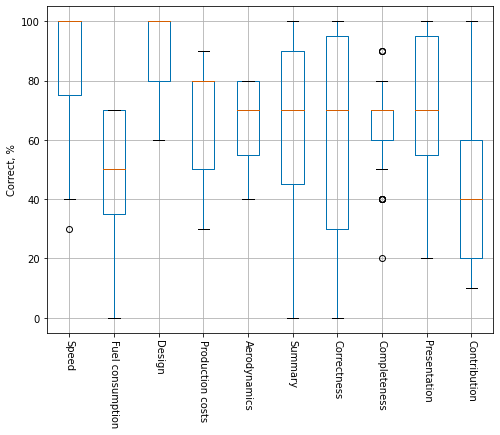

In [59]:
fig, ax = plt.subplots(figsize=FIGSIZE)
perc_normalized_scores_df.boxplot(ax=ax)
ax.tick_params(axis='x', labelrotation = -90)
ax.set(ylabel='Correct, %')
# fig.show()
savefig(fig, 'questions_boxplot')

#### Score Points Plot

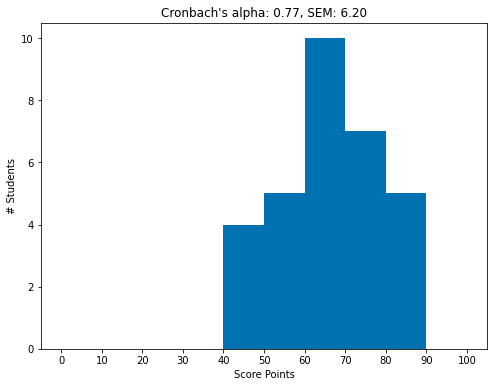

In [60]:
fig, ax = plt.subplots(figsize=FIGSIZE)
score_points_df[STUDENT_SCORE_POINTS_COLUMN].plot.hist(
    bins=range(0, 100, 10),
    ax=ax,
    xticks=range(0, 101, 10),
    xlim=(-5,105)
)
ax.set_xlabel('Score Points')
ax.set_ylabel('# Students')
ax.set_title("Cronbach's alpha: {:.2f}, SEM: {:.2f}".format(alpha, SEM_SP))
# fig.show()
savefig(fig, 'score_points')

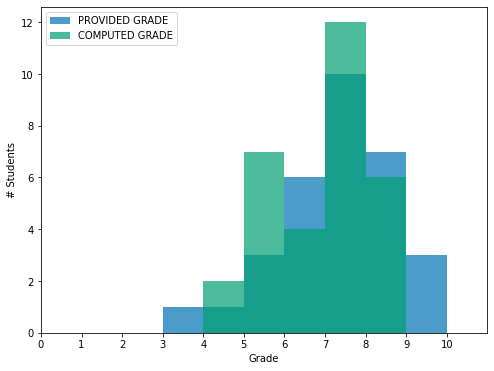

In [62]:
fig, ax = plt.subplots(figsize=FIGSIZE)
if grades is not None:
    score_points_df[[GRADE_COLUMN, COMPUTED_GRADE_COLUMN]].plot.hist(
        ax=ax,
        bins=range(MIN_GRADE-1, MAX_GRADE+1, 1),
        xticks=range(MIN_GRADE-1, MAX_GRADE+1, 1),
        xlim=(MIN_GRADE-1, MAX_GRADE+1),
        alpha=0.7,
    )
    ax.legend(loc='upper left', labels=['PROVIDED GRADE', 'COMPUTED GRADE'])
else:
    score_points_df[COMPUTED_GRADE_COLUMN].plot.hist(
        ax=ax,
        bins=range(MIN_GRADE-1, MAX_GRADE+1, 1),
        xticks=range(MIN_GRADE-1, MAX_GRADE+1, 1),
        xlim=(MIN_GRADE-1, MAX_GRADE+1),
    )
    ax.legend(loc='upper left', labels=['COMPUTED GRADE'])
ax.set_xlabel('Grade')
ax.set_ylabel('# Students')

savefig(fig, 'grades_distribution')

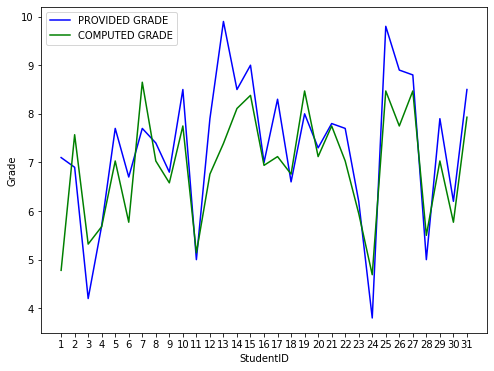

In [64]:
fig, ax = plt.subplots(figsize=FIGSIZE)
if grades is not None:
    ax.plot(
        score_points_df.index,
        score_points_df[GRADE_COLUMN],
        'b-',
        label='PROVIDED GRADE',
    )

ax.plot(
    score_points_df.index,
    score_points_df[COMPUTED_GRADE_COLUMN],
    'g-',
    label='COMPUTED GRADE',
)
ax.legend()
ax.set_xlabel(INDEX_COLUMN)
ax.set_ylabel('Grade')
savefig(fig, 'grades_for_students')

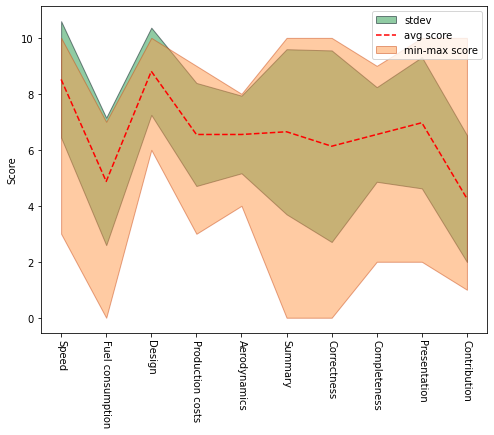

In [65]:
fig, ax = plt.subplots(figsize=FIGSIZE)

ax.fill_between(questions_res_df.index,
    questions_res_df['avg_student_score_points'] - questions_res_df['stdev_sp'], 
    questions_res_df['avg_student_score_points'] + questions_res_df['stdev_sp'], 
    alpha=0.5, edgecolor='#00111B', facecolor='#229848',
    label='stdev'
)

ax.plot(
    questions_res_df.index,
    questions_res_df['avg_student_score_points'],
    'r--',
    label = 'avg score',
)

ax.fill_between(questions_res_df.index,
    questions_res_df['min_scores'], 
    questions_res_df['max_scores'],
    alpha=0.5, edgecolor='#CC4F1B', facecolor='#FF9848',
    label = 'min-max score',
)

ax.legend()
ax.tick_params(axis='x', labelrotation = -90)
ax.set_ylabel('Score')
# fig.show()
savefig(fig, 'questions_results')

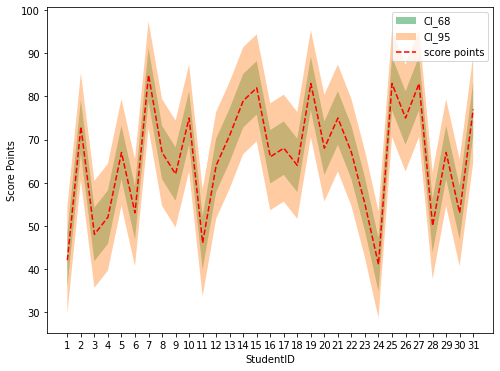

In [66]:
fig, ax = plt.subplots(figsize=FIGSIZE)

ax.fill_between(score_points_df.index,
    score_points_df['MIN_CI_68'],
    score_points_df['MAX_CI_68'], 
    alpha=0.5, facecolor='#229848',
    label='CI_68'
)

ax.fill_between(score_points_df.index,
    score_points_df['MIN_CI_95'],
    score_points_df['MAX_CI_95'], 
    alpha=0.5, facecolor='#FF9848',
    label='CI_95'
)

ax.plot(
    score_points_df.index,
    score_points_df[STUDENT_SCORE_POINTS_COLUMN],
    'r--',
    label='score points',
)

ax.legend()
ax.set_xlabel(INDEX_COLUMN)
ax.set_ylabel('Score Points')
# fig.show()
savefig(fig, 'students_results')